#  Introduction au apprentissage par renforcement

### Explorer des graphes de possibilités



Enormément de problèmes se formalisent comme des problèmes d'explorations d'arbre "de possibilités". Par exemple: trouver le meilleurs coup au échec.

On a un arbtre "min-max" car

* les blancs essaieront de maximiser le score quand c'est à eux de jouer
* les noirs essaieront de minimiser le score quand c'est à eux de jouer

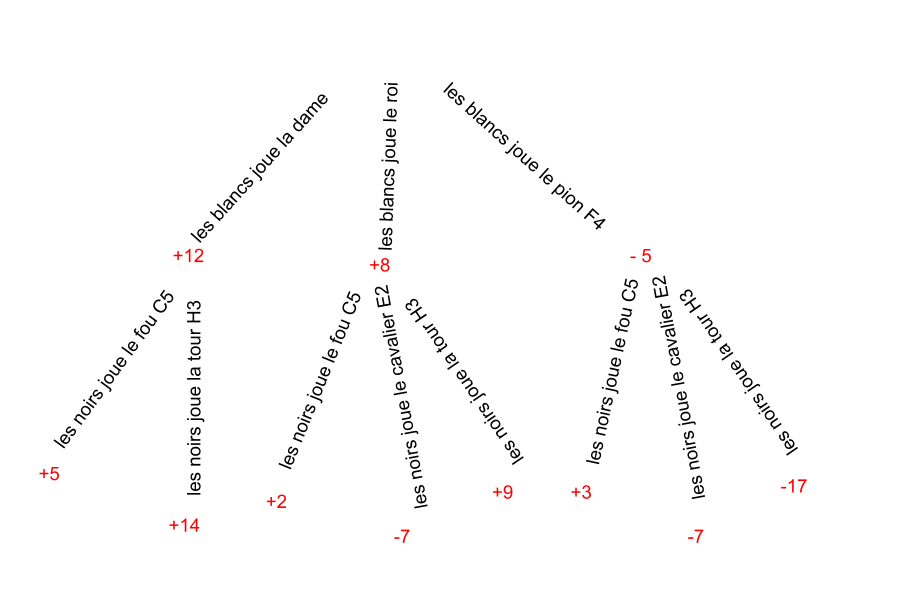

On a deux type d'exploration possible:

1- En favorisant la largeur: on essaye presque toutes les possibilités à un étage avant l'explorer l'étage suivant.

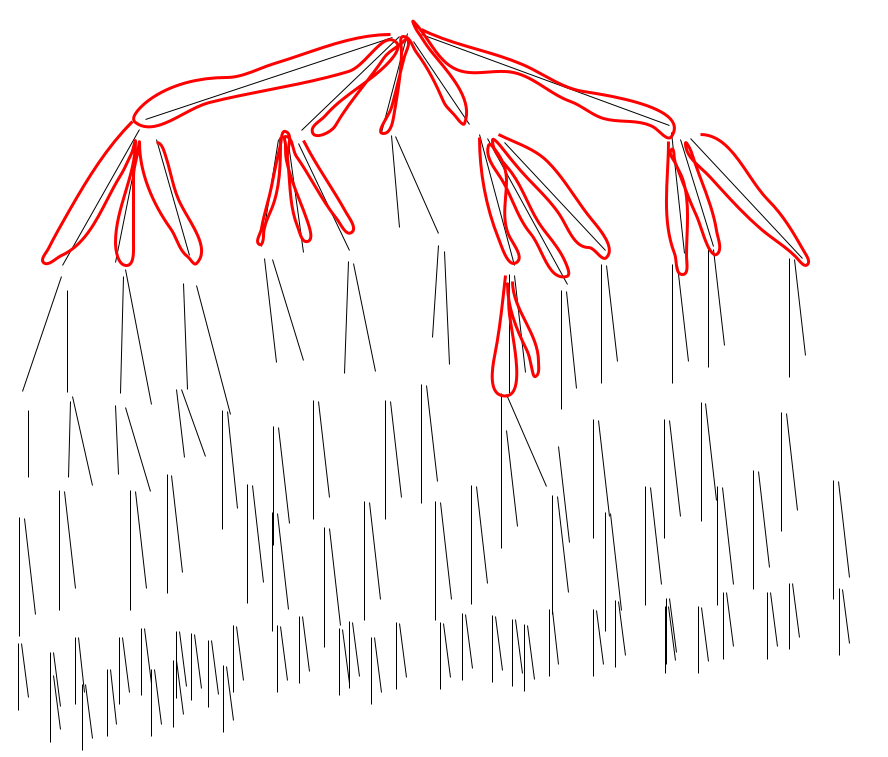

2 - en favorisant la profondeur: on explore longtemps des branches

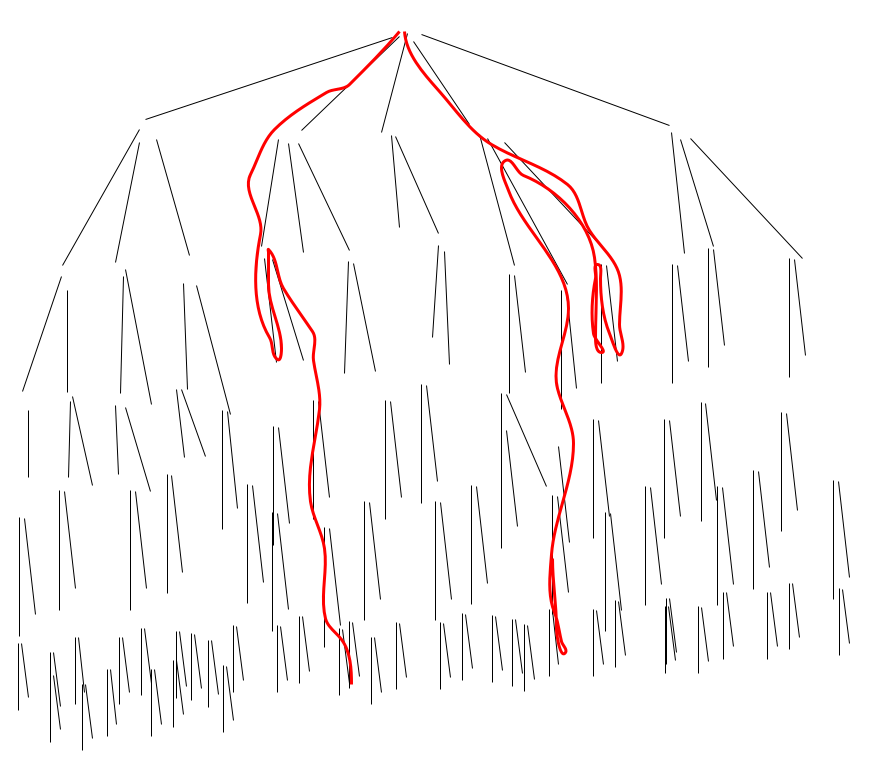

Dans quasi tous les problèmes, le bon score d'un parent favorise un bon score pour les enfants.

En particulier les branches soeurs, cousine ... on des score proches. On a ainsi une continuité de notre environnement.

Parfois on peut avoir encore mieux: les branches soeurs sont ordonnées, et il y a une certaine continuité des score selon cet ordre.

C'est notamment le cas des arbres de possibilités dont les bifurcations sont infinies.



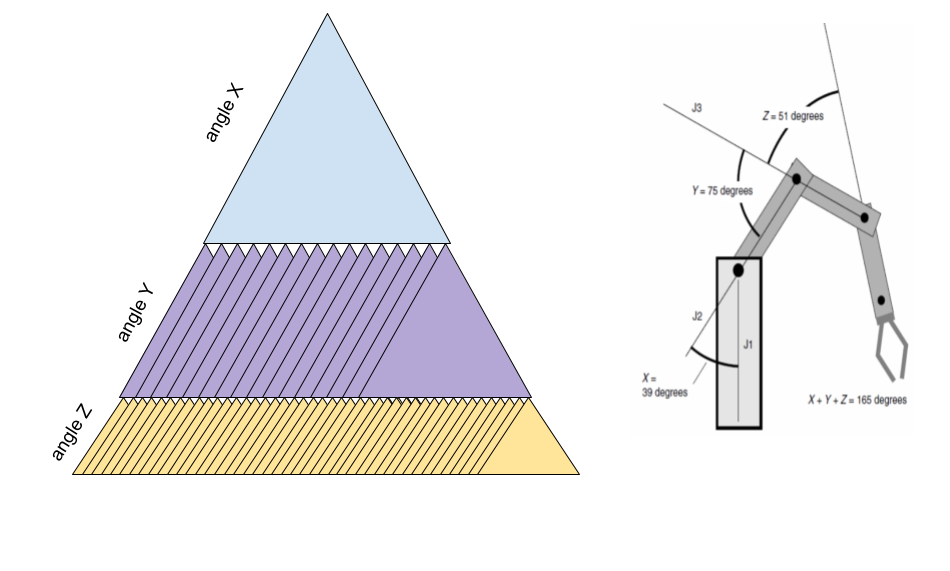

## Q-learning

### Environnement

On va formaliser un abre de possibilité via une fonction "environement".

On considère des états $(s)$ et des actions $(a)$. Une action permet de passer d'un état $s$ à un état $s'$ tout en récoltant une récompense $r$. On formalise cela par la fonction "environement":
$$
s', r = env(s,a)
$$

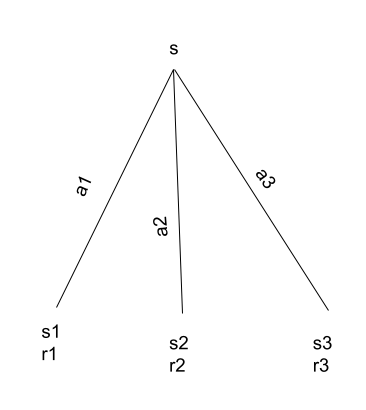


Nous noterons  $A_s$ l'ensemble des actions possibles au départ de $s$.

***Exemple:*** les états sont les indices  $(i,j)$ de la matrice  ci-dessous. Une action est de se déplacer dans cette matrice d'une case vers le haut/bas ou droite/gauche. La récompense est la valeur de la case d'arrivée.
```
           j=  0   1   2
        i=
         0   [ 0, -3, 10],
         1   [ 3, -1, 0 ],
         2   [-1, -1, 0 ],
         3   [ 0,  0, 0 ],
        
```
 Et on a par exemple:
$$
(0,1) , -3 = env\big((0,0), droite \big)
$$


L'objectif est de trouver une trajectoire $t\to s_t,a_t$ permettant de récolter un maximum de récompense $r_t$. On pondère ces récompenses avec avec un "discount factor" $\gamma$, la récompense-cumulée est définie par:
$$
\sum_{t \geq 0} \gamma^{t} r_{t}
$$


**En particulier:**
* Plus $\gamma$ est proche de 1 et plus on s'interesse aux gains à long terme.
* Avec $\gamma=1$ on somme une infinité de récompenses ce qui peut poser des problèmes.
* avec $\gamma=0$, en prenant la convention $0^0=1$, la quantité à maximiser est simplement $r_0$. La stratégie est donc très simple: partant de $s_0$, je choisis $a_0$ qui donne accès à la plus grande récompense. Avec cette vision à court terme, on ne prend jamais le risque de visiter un état donnant une mauvaise récompense, pour en obternir une meilleurs au coup suivant. Dans l'exemple précédent, cette stratégie ménerait à faire des allez-retours entre  $(0,0)$ et $(1,0)$ sans jamais visiter l'état $(0,2)$ qui donne pourtant la récompense maximale.  
* On choisi en général $\gamma$ autour de $0.9$.


***Remarque:*** Parfois il y a des environnements aléatoires: $env(s,a)$ renvoie 2 variables aléatoires. Dans ce cas, ce qu'il faut maximiser c'est
$$
\mathbb E\big[\sum_{t \geq 0} \gamma^{t} r_{t} \big]
$$







### La $Q$-fonction optimale

On veut maximiser la récompense-cumulée pour tout point de départ $(s,a)$. On note alors:
$$
Q^{opt}[s,a] := \max \Big( \sum_{t\geq 0} \gamma^t r_t  \ \big | \  (s_t,a_t)_{t\geq 0} : s_0=s,a_0=a\Big)
$$
la notation $|$ indique que le max est pris sur toutes les trajectoires $t\to (s_t,a_t)$ démarrant en $(s_0,a_0)=(s,a)$.

La matrice $Q^{opt}[s,a]$ est appelée $Q$-fonction optimale, ou bien récompense-cumulée optimale.


Si nous connaissons $Q^{opt}[s,a]$, alors nous connaissons aussi  la stratégie qui permet de l'obtenir: Partant de $s_0$, la première action à choisir est
$$
a_0 = \text{argmax}_{a\in A_{s_0}} Q^{opt}[s_0,a]
$$
Et pour la suite: cette action $a_0$ nous mène à un état $s_1$ et il la seconde action à choisir est:
$$
a_1 = \text{argmax}_{a\in A_{s_1}} Q^{opt}[s_1,a]
$$
etc.


### Politique

De manière générale une politique  (ou stratégie) est une fonction qui à tout début de trajectoire $(s_0,...,s_t)$ associe une action $a_t$ qui permet d'aller à l'état suivant $s_{t+1}$. En d'autre terme, une stratégie c'est une manière de construire une trajectoire.

Une stratégie est dite markovienne si elle ne dépend que de l'instant présent $s_t$ (elle ne dépend ni des états du passé, ni du temps $t$).

Ainsi une stratégie Markovienn est  définie par une simple fonction $\mu$   qui a un état $s$ associe une action $\mu(s)$. Nous avons vu précédemment que la récompense-cumulée maximale est optenue avec une stratégie Markovienne:
$$
\mu^{opt}(s) = \text{argmax}_{a\in A_{s}} Q^{opt}[s,a]
$$
Mais bien entendu, la difficulté c'est de calculer ce $Q^{opt}$.

### Etat terminaux

Un environnement peut contenir des états  terminaux: aucune action n'est possible à partir d'eux. Exemple: Un echec-et-mat au jeu d'échecs.

On prend la convention de dire que, au départ d'un état terminal il n'y a qu'une action possible qui mène vers un état cimetière (artificiel), et les récompenses qui mènent à cet état cimetière sont toutes nulles. Par conséquent, quand $s$ est un état terminal, on a $\max_{a} Q^{opt}[s,a]=0$.


Mais attention: si un état terminal fait gagner/perdre une partie, il faut penser à associer une grande récompense positive/négative à l'action qui y mène: par exemple quand on a $s',r = env(s,a)$ avec $s'$ état "gagnant" alors $r$ est très grand et puisque toutes les trajectoires possible vont au cimetière on a:
$$
Q^{opt}[s,a] = r
$$

***Remarque:*** En pratique, les jeux doivent se terminer, donc s'il n'y a pas d'état terminal, on en introduit un artificiellement en introduisant un compteur de coup.


### Equation de Bellman optimale

***Théorème:*** Considérons un état et une action $s,a$. Notons  $s',r= env(s,a)$.  La matrice $Q^{opt}$ vérifie:   
$$
Q^{opt}[s,a] = r + \gamma \max_{a'\in A_{s'}} Q^{opt}[s',a']
$$



*Démonstration:*
\begin{align}
Q^{opt}[s,a] & = \max \Big( \sum_{t\geq 0} \gamma^t r_t  \ \big | \  (s_t,a_t)_{t\geq 0} : s_0=s,a_0=a\Big)\\
& = \max \Big( \sum_{t\geq 0} \gamma^t r_t  \ \big | \  (s_t,a_t)_{t\geq 0} : s_0=s,a_0=a,s_1=s',r_0=r\Big) \\
& = \max \Big(r + \sum_{t\geq 1} \gamma^t r_t  \ \big | \  (s_t,a_t)_{t\geq 1} : s_1=s'\Big)\\
& = \max \Big(r + \sum_{t\geq 1} \gamma^t r_t  \ \big | \  (s_t,a_t)_{t\geq 1} : s_1=s',a_1\in A_{s'}\Big)
\end{align}

\begin{align}
 &= \max \Big( r +  \gamma  \sum_{t\geq 0} \gamma^t r_{t+1}  \ \big | \  (s_t,a_t)_{t\geq 1} : s_1=s',  a_1\in A_{s'} \Big)\\
 &= r +\gamma  \max \Big( \sum_{t\geq 0} \gamma^{t} r_{t+1}  \ \big | \  (s_t,a_t)_{t\geq 1} : s_1=s',  a_1\in A_{s'} \Big)\\
 &= r +\gamma  \max_{a'\in A_{s'}}\max \Big( \sum_{t\geq 0} \gamma^{t} r_{t+1}  \ \big | \  (s_t,a_t)_{t\geq 1} : s_1=s',  a_1=a'\Big)\\
 &=  r + \gamma \max_{ a' \in A_{s'}} Q^{opt}[s',a']
\end{align}

**Vocabulaire:** On définit la fonction valeur optimale $V^{opt}$ par:
$$
V^{opt}[s]=max_a Q^{opt}[s,a]
$$

Avec l'équation de Bellman optimale on peut aussi déduire $Q^{opt}$ de $V^{opt}$:
$$
Q^{opt}[s,a] = r + \gamma V^{opt}[s']
$$
avec $s',r=env(s,a)$.

Certain algo sont basés sur l'estimation directe de $V^{opt}$. Mais remarquons que $Q^{opt}$ est plus pratique pour exprimer la politique optimale.


### Point fixe

***Presque théorème:*** Si une matrice $Q$ satisfait
$$
Q[s,a] \approx r + \gamma \max_{a'\in A_{s'}} Q[s',a']
$$
alors
$$
Q \approx Q^{opt}
$$

Pour trouver  un $Q$ satisfaisant presque l'équation de Bellman optimale, on va utiliser la technique du point fixe: On initialise une matrice $Q^0$ à zéro.

Puis on se donne plein quatrduplets $(s_i,a_i,s'_{i},r_i)$ avec $s'_i,r_i=env(s_i,a_i)$ et  l'on itére:

$$
Q^{i+1}[s_i,a_i] = r_i + \gamma \max_{a'} Q^i[s'_i,a']
$$



Mais comment choisit-on les quadruplets $(s_i,a_i,s'_{i},r_i)$ ? On part d'un état $s_0$ aléatoire, puis on suit une trajectoire jusqu'à un état final, en choisissant à chaque pas l'action en suivant l'$\epsilon$-stratégie ($\epsilon$-greedy in english):

* Avec proba $\epsilon$ on en choisit une action aléatoire dans $A_s$. C'est l'*exploration*.
* Avec proba $1-\epsilon$ on prend le $a$ qui maximise le $Q[s,a]$ courant. C'est l'*exploitation*: on prend en compte que notre $Q$ courant est assez proche du $Q^{opt}$ et donc que la trajectoire qu'il fournit est assez proche de la trajectoire optimale.




***Variante:***  On peut aussi utiliser une version "avec intertie" du point fixe:
$$
Q[s,a] \leftarrow (1-\alpha) Q[s,a] + \alpha (  r + \gamma \max_{a'} Q[s',a'])
$$


### L'algo











Résumons l'algo:

* On part de l'état $s$.
* On choisit une action $a\in A_s$ suivant  l'$\epsilon$-stratégie, ce qui conduit à  l'état $s'$ et donne la récompense $r$.
* On modifie la matrice $Q$:
$$
Q[s,a] \leftarrow  r + \gamma \max_{a'} Q[s',a']
$$
* on diminue $\epsilon$
* si $s$ n'est pas terminal, on repart de la première étape avec $s\leftarrow s'$.
* sinon, l'épisode est fini, on repart d'un $s$  aléatoire.


Vocabulaire: un "épisode" c'est les étapes de l'algo entre le tirage d'un $s$ aléatoire, et l'arrivée dans un état terminal.



## Deep Q learning


### Principe

Supposons maintenant que l'ensemble des états $s$ est continue (une partie de $\mathbb R^n$), mais que l'ensemble des actions $a$ est toujours discret.  Ainsi $Q^{opt}[s,a]$ est maintenant une fonction, que l'on espère un peu régulière en $s$.

On essaye de l'approximer par un réseau de neurone $Q_w$ où $w$ est représente les poids (ou paramètres) du réseau.


Voici l'algorithme:
* On part de l'état $s$.
* On choisi une action $a$ suivant notre $\epsilon$-stratégie qui nous donne accès à un état $s'$ et à une récompense $r$.
* On stocke $(s,a,s',r)$ dans notre mémoire. Si la mémoire ne dépasse pas `batch_size` on repart de la première étape avec $s\leftarrow s'$. Sinon:
* On tire un batch de $(s,a,s',r)$ dans notre mémoire et on modifie $w$ par back-propagation du gradient, pour miniser la distance entre les:
$$
Q_{w}[s,a] \qquad \text{ et } \qquad     r + \gamma \max_{a'} Q_{w}[s',a']
$$
* on diminue $\epsilon$
* si $s'$ n'est pas terminal, on repart de la première étape avec $s\leftarrow s'$.
* sinon on repart d'un $s$ aléatoire.






























### En pratique


 Puisque $s\in\mathbb R^n$ est continu et $a\in [1,2,...,k]$ est discret, on va prendre comme réseau de neurone un multi-perceptron $M_w$ allant de $\mathbb R^n$ vers $\mathbb R^k$. Et ensuite on prendra:
$$
Q_w[s,a] = M_w(s)_a
$$
Pour actualiser les poids $w$ on utilise la stratégie suivante: On calcul
$$
y= r + \gamma \max M_{w}(s') = r + \gamma \max_{a'} Q_{w}[s',a']
$$
puis on applique les gradients pour diminuer
$$
(y - Q_w[s,a])^2
$$

